## Cities: Leicestershire, Durham, London, Surrey
###  Date: October 2024 - November 2025

# **ACTIVITY-1**

## **Importing Libraries**

In [7]:
#Importing libraries and created spark session
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[2]").appName("dataframe").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(spark)
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
import csv
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# **Importing Data**

In [8]:
#Unzipping th data and moving it to a folder named my_data
!unzip "/content/my_data.zip" -d "my_data"

Archive:  /content/my_data.zip
  inflating: my_data/2023-11/2023-11-city-of-london-street.csv  
  inflating: my_data/2023-11/2023-11-durham-street.csv  
  inflating: my_data/2023-11/2023-11-leicestershire-street.csv  
  inflating: my_data/2023-11/2023-11-surrey-street.csv  
  inflating: my_data/2023-12/2023-12-city-of-london-street.csv  
  inflating: my_data/2023-12/2023-12-durham-street.csv  
  inflating: my_data/2023-12/2023-12-leicestershire-street.csv  
  inflating: my_data/2023-12/2023-12-surrey-street.csv  
  inflating: my_data/2024-01/2024-01-city-of-london-street.csv  
  inflating: my_data/2024-01/2024-01-durham-street.csv  
  inflating: my_data/2024-01/2024-01-leicestershire-street.csv  
  inflating: my_data/2024-01/2024-01-surrey-street.csv  
  inflating: my_data/2024-02/2024-02-city-of-london-street.csv  
  inflating: my_data/2024-02/2024-02-durham-street.csv  
  inflating: my_data/2024-02/2024-02-leicestershire-street.csv  
  inflating: my_data/2024-02/2024-02-surrey-street

In [9]:
import os
import shutil
# Moving the data files from date separated folders to a directory named UK_crime_data
os.mkdir('UK_crime_data')

In [10]:
for r, d, f in os.walk('my_data'):
  for file in f:
    print(os.path.join(r,file))
    if file.endswith(".csv"):
      shutil.move(os.path.join(r,file), "UK_crime_data")

my_data/2025-02/2025-02-leicestershire-street.csv
my_data/2025-02/2025-02-durham-street.csv
my_data/2025-02/2025-02-city-of-london-street.csv
my_data/2025-02/2025-02-surrey-street.csv
my_data/2024-11/2024-11-city-of-london-street.csv
my_data/2024-11/2024-11-surrey-street.csv
my_data/2024-11/2024-11-leicestershire-street.csv
my_data/2024-11/2024-11-durham-street.csv
my_data/2025-03/2025-03-durham-street.csv
my_data/2025-03/2025-03-surrey-street.csv
my_data/2025-03/2025-03-leicestershire-street.csv
my_data/2025-03/2025-03-city-of-london-street.csv
my_data/2025-07/2025-07-surrey-street.csv
my_data/2025-07/2025-07-durham-street.csv
my_data/2025-07/2025-07-city-of-london-street.csv
my_data/2025-07/2025-07-leicestershire-street.csv
my_data/2025-04/2025-04-leicestershire-street.csv
my_data/2025-04/2025-04-city-of-london-street.csv
my_data/2025-04/2025-04-durham-street.csv
my_data/2025-04/2025-04-surrey-street.csv
my_data/2024-12/2024-12-durham-street.csv
my_data/2024-12/2024-12-city-of-london

In [11]:
from pyspark.sql.functions import input_file_name, regexp_extract, initcap, regexp_replace, to_date

# Load all city CSVs at once
AllCitiesCrime = spark.read \
    .option("header", "true") \
    .option("delimiter", ",") \
    .option("inferSchema", "true") \
    .csv("/content/UK_crime_data/*-street.csv")

# Extract city name from filename
AllCitiesCrime = AllCitiesCrime.withColumn(
    "City",
    initcap(
        regexp_replace(
            regexp_extract(input_file_name(), r"([a-zA-Z]+)-street\.csv$", 1),
            "-", " "
        )
    )
)

# Convert Month column to proper date
AllCitiesCrime = AllCitiesCrime.withColumn("Month", to_date("Month", "yyyy-MM-dd"))


## **Data Preprocessing**

In [12]:
# Removing unwanted columns and Total Record Counts
AllCitiesCrime = AllCitiesCrime.drop('Reported by','Falls within','Longitude', 'Latitude', 'Context', 'LSOA code', 'LSOA name', 'Last outcome')
AllCitiesCrime.show(5, truncate=False)
total_records = AllCitiesCrime.count()
print(f"Total number of records: {total_records}")

+----------------------------------------------------------------+----------+-------------------------+----------------------------+---------------------------+--------------+
|Crime ID                                                        |Month     |Location                 |Crime type                  |Last outcome category      |City          |
+----------------------------------------------------------------+----------+-------------------------+----------------------------+---------------------------+--------------+
|6e8200628c7c31284ab1d0c8e9bc2edabb314933a591df74c967d7f3a9d228a8|2025-05-01|On or near Elm Avenue    |Violence and sexual offences|Unable to prosecute suspect|Leicestershire|
|34c838d4345e671afe9f653ecedf458db36c1f84563149ce9d44a538bc581c47|2025-05-01|On or near Carrswood View|Violence and sexual offences|Status update unavailable  |Leicestershire|
|6bb25452fb25e309a644bca923110b6573d8d85dffa3d3b982c29325df2a5902|2025-05-01|On or near A5134         |Other crime      

In [13]:
# Renaming Column name
AllCitiesCrime = AllCitiesCrime.withColumnRenamed('Crime ID', 'Crime_ID')
AllCitiesCrime= AllCitiesCrime.withColumnRenamed('Crime type', 'Crime_type')

In [14]:
# Adding new columns: Month_Num, Month_Name and Year
from pyspark.sql.functions import month, year, date_format

AllCities_month_df = AllCitiesCrime \
    .withColumn("Month_Num", month("Month")) \
    .withColumn("Month_Name", date_format("Month", "MMMM")) \
    .withColumn("Year", year("Month"))


In [15]:
AllCities_month_df.show(5)

+--------------------+----------+--------------------+--------------------+---------------------+--------------+---------+----------+----+
|            Crime_ID|     Month|            Location|          Crime_type|Last outcome category|          City|Month_Num|Month_Name|Year|
+--------------------+----------+--------------------+--------------------+---------------------+--------------+---------+----------+----+
|6e8200628c7c31284...|2025-05-01|On or near Elm Av...|Violence and sexu...| Unable to prosecu...|Leicestershire|        5|       May|2025|
|34c838d4345e671af...|2025-05-01|On or near Carrsw...|Violence and sexu...| Status update una...|Leicestershire|        5|       May|2025|
|6bb25452fb25e309a...|2025-05-01|    On or near A5134|         Other crime| Status update una...|Leicestershire|        5|       May|2025|
|b283ea49de73f7b2b...|2025-05-01|On or near Algern...|Violence and sexu...| Unable to prosecu...|Leicestershire|        5|       May|2025|
|a1797aac5a2cd8eee...|2025-

# **Total Crimes Per Year Across All Cities**

In [16]:
#Total Crimes Per Year Across All Cities
TotalCrimesPerYear = AllCities_month_df.groupBy("Year") \
    .agg(count("*").alias("Total_Crimes")) \
    .orderBy("Year")

TotalCrimesPerYear.show()


+----+------------+
|Year|Total_Crimes|
+----+------------+
|2023|       44320|
|2024|      278383|
|2025|      234325|
+----+------------+



In [17]:
# Data Visualization
# Convert to Pandas for plotting
TotalCrimesPerYear_pd = TotalCrimesPerYear.toPandas()

# Ensure Year is treated as string for clean x-axis
TotalCrimesPerYear_pd['Year'] = TotalCrimesPerYear_pd['Year'].astype(str)

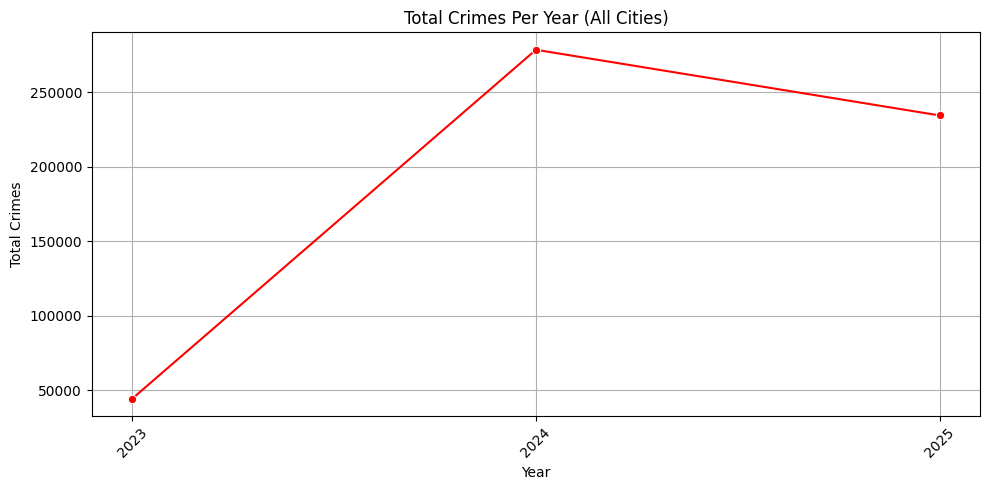

In [18]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=TotalCrimesPerYear_pd,
    x='Year',
    y='Total_Crimes',
    marker='o',
    color='red'
)

plt.title("Total Crimes Per Year (All Cities)")
plt.xlabel("Year")
plt.ylabel("Total Crimes")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# **Annual Crime Trend For Each City**

In [19]:
# Annual Crime Trend For Each City
TotalCrimesPerYear_City = AllCities_month_df.groupBy("City", "Year") \
    .agg(count("*").alias("Total_Crimes")) \
    .orderBy("City", "Year")

TotalCrimesPerYear_City.show()


+--------------+----+------------+
|          City|Year|Total_Crimes|
+--------------+----+------------+
|        Durham|2023|       11534|
|        Durham|2024|       73518|
|        Durham|2025|       62225|
|Leicestershire|2023|       16925|
|Leicestershire|2024|      107902|
|Leicestershire|2025|       90485|
|        London|2023|        1690|
|        London|2024|        9992|
|        London|2025|        7331|
|        Surrey|2023|       14171|
|        Surrey|2024|       86971|
|        Surrey|2025|       74284|
+--------------+----+------------+



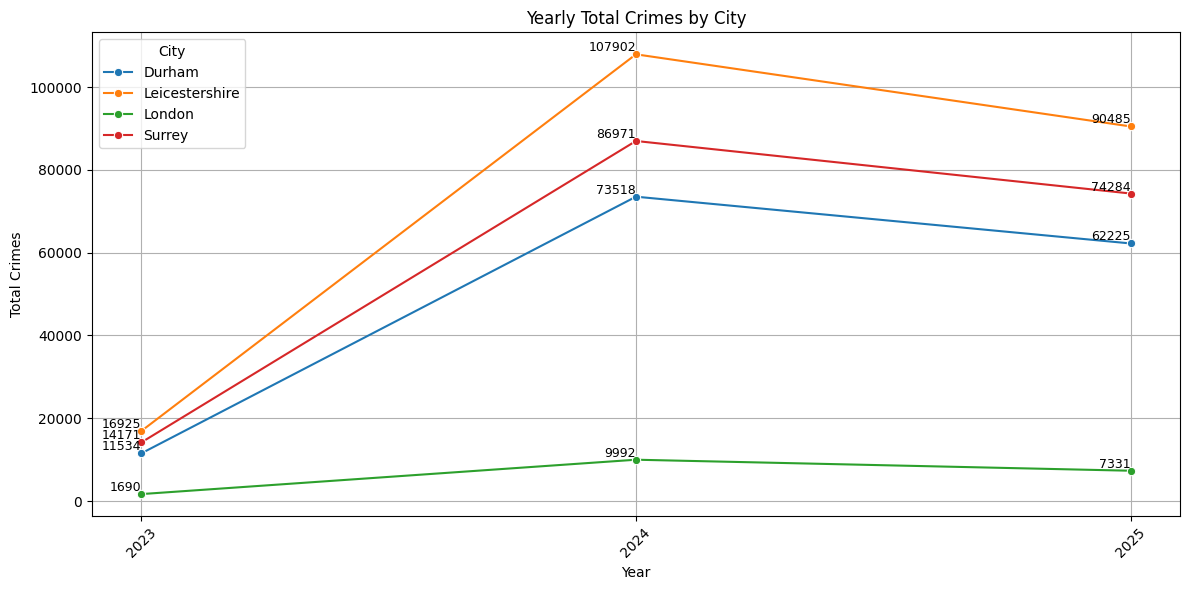

In [20]:
# Convert to Pandas
TotalCrimesPerYear_City_pd = TotalCrimesPerYear_City.toPandas()

TotalCrimesPerYear_City_pd['Year'] = TotalCrimesPerYear_City_pd['Year'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=TotalCrimesPerYear_City_pd,
    x='Year',
    y='Total_Crimes',
    hue='City',
    marker='o'
)

# Annotate points
for i, row in TotalCrimesPerYear_City_pd.iterrows():
    plt.text(
        x=row['Year'],
        y=row['Total_Crimes'] + 1,  # small offset
        s=int(row['Total_Crimes']),
        ha='right',
        va='bottom',
        fontsize=9
    )

plt.title("Yearly Total Crimes by City")
plt.xlabel("Year")
plt.ylabel("Total Crimes")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Most Prevalent Crime Types Across All Cities**

In [21]:
# Most Prevalent Crime Types Across All Cities
from pyspark.sql.functions import count
# Aggregate most common crimes across all cities
CrimeCounts_AllCities = AllCities_month_df.groupBy("Crime_type") \
    .agg(count("*").alias("Count")) \
    .orderBy("Count", ascending=False)  # just pass column name as string

CrimeCounts_AllCities.show(10,truncate = False)


+----------------------------+------+
|Crime_type                  |Count |
+----------------------------+------+
|Violence and sexual offences|193501|
|Anti-social behaviour       |80621 |
|Criminal damage and arson   |50833 |
|Public order                |47464 |
|Shoplifting                 |45965 |
|Other theft                 |38295 |
|Vehicle crime               |28572 |
|Burglary                    |23540 |
|Drugs                       |15307 |
|Other crime                 |13712 |
+----------------------------+------+
only showing top 10 rows


In [22]:
CrimeCounts_AllCities_pd = CrimeCounts_AllCities.toPandas()
# select top 10 most common crime types
top_crimes = CrimeCounts_AllCities_pd.head(10)


/tmp/ipython-input-1071405919.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


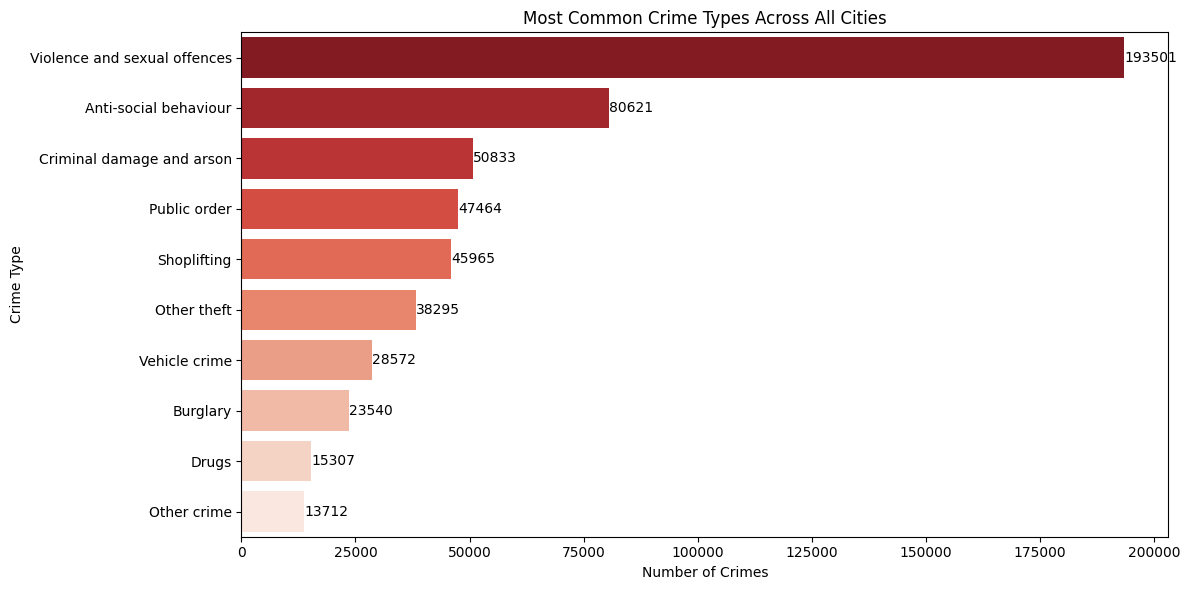

In [23]:
# Data Visualization of Most Common Crime Types Across the Cities
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_crimes,
    y='Crime_type',
    x='Count',
    palette='Reds_r'
)
# Add values on bars
for bar in ax.patches:
    ax.text(
        bar.get_width(), # value at end of bar
        bar.get_y() + bar.get_height()/2,
        int(bar.get_width()),# showing the number
        va='center'
    )
plt.title("Most Common Crime Types Across All Cities")
plt.xlabel("Number of Crimes")
plt.ylabel("Crime Type")
plt.tight_layout()
plt.show()


# **City-Wise Analysis of Crime Type Distribution**

In [39]:
#City-Wise Analysis of Crime Type Distribution
#Aggregate counts per city and crime type
CrimeType_ByCity = (
    AllCities_month_df.groupBy("City", "Crime_type")
    .agg(count("*").alias("Count"))
    .orderBy("City", "Crime_type"))

In [42]:
CrimeType_ByCity_pd = CrimeType_ByCity.toPandas() #Convert to Pandas for plotting
# Sum counts per Crime_type across all cities
top_crimes = (
    CrimeType_ByCity_pd.groupby("Crime_type")["Count"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()) # convert Index to list

# Filter DataFrame to include only top crimes
CrimeType_ByCity_top = CrimeType_ByCity_pd[
    CrimeType_ByCity_pd['Crime_type'].isin(top_crimes)]


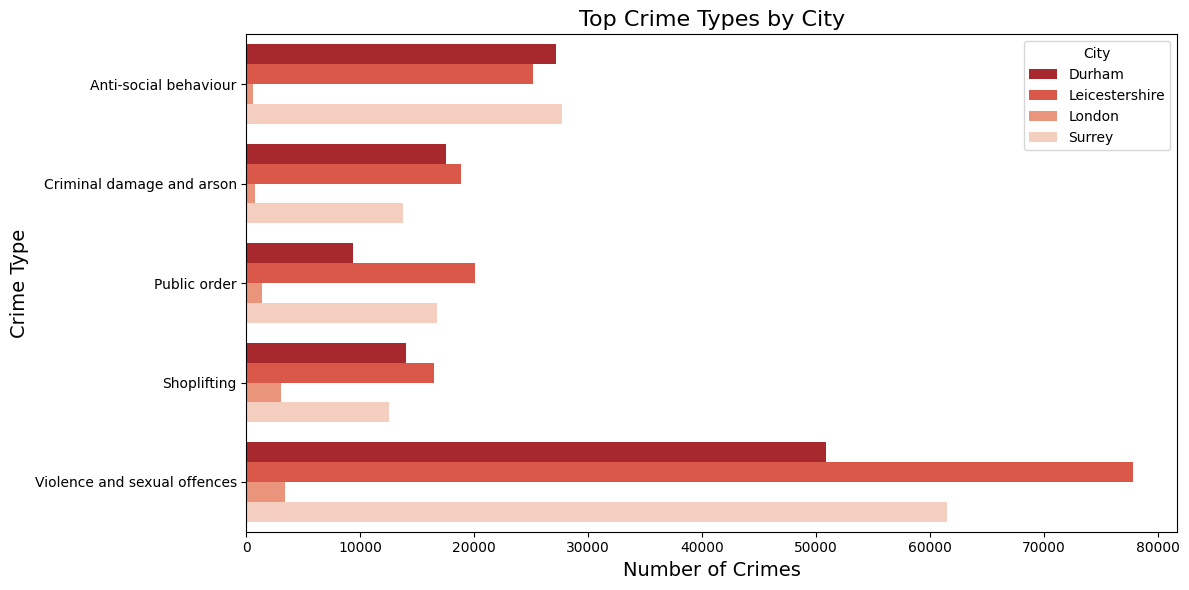

In [43]:
# Data Visualization
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=CrimeType_ByCity_top,
    y="Crime_type",
    x="Count",
    hue="City",
    palette="Reds_r")

plt.title("Top Crime Types by City", fontsize=16)
plt.xlabel("Number of Crimes", fontsize=14)
plt.ylabel("Crime Type", fontsize=14)
plt.legend(title="City")
plt.tight_layout()
plt.show()


# **City-Wise Monthly Crime Trends**

In [51]:
# City-Wise Monthly Crime Trends
Monthly_Crime_ByCity = ( #Extract month from date and count crimes per month
    AllCities_month_df
    .withColumn("Month_Num", month("Month"))
    .withColumn("Month_Name", date_format("Month", "MMMM"))
    .groupBy("City", "Month_Num", "Month_Name")
    .agg(count("*").alias("Total_Crimes"))
    .orderBy("City", "Month_Num"))
Monthly_Crime_ByCity.show(5)

+------+---------+----------+------------+
|  City|Month_Num|Month_Name|Total_Crimes|
+------+---------+----------+------------+
|Durham|        1|   January|       11161|
|Durham|        2|  February|       10749|
|Durham|        3|     March|       12494|
|Durham|        4|     April|       12381|
|Durham|        5|       May|       13151|
+------+---------+----------+------------+
only showing top 5 rows


In [47]:
# Data Visualization
Monthly_Crime_ByCity_pd = Monthly_Crime_ByCity.toPandas() # Convert to Pandas
# Selecting month in accurate order
months_order = ["January", "February", "March", "April", "May", "June",
                "July", "August", "September", "October", "November", "December"]

Monthly_Crime_ByCity_pd['Month_Name'] = pd.Categorical(
    Monthly_Crime_ByCity_pd['Month_Name'],
    categories=months_order,
    ordered=True )

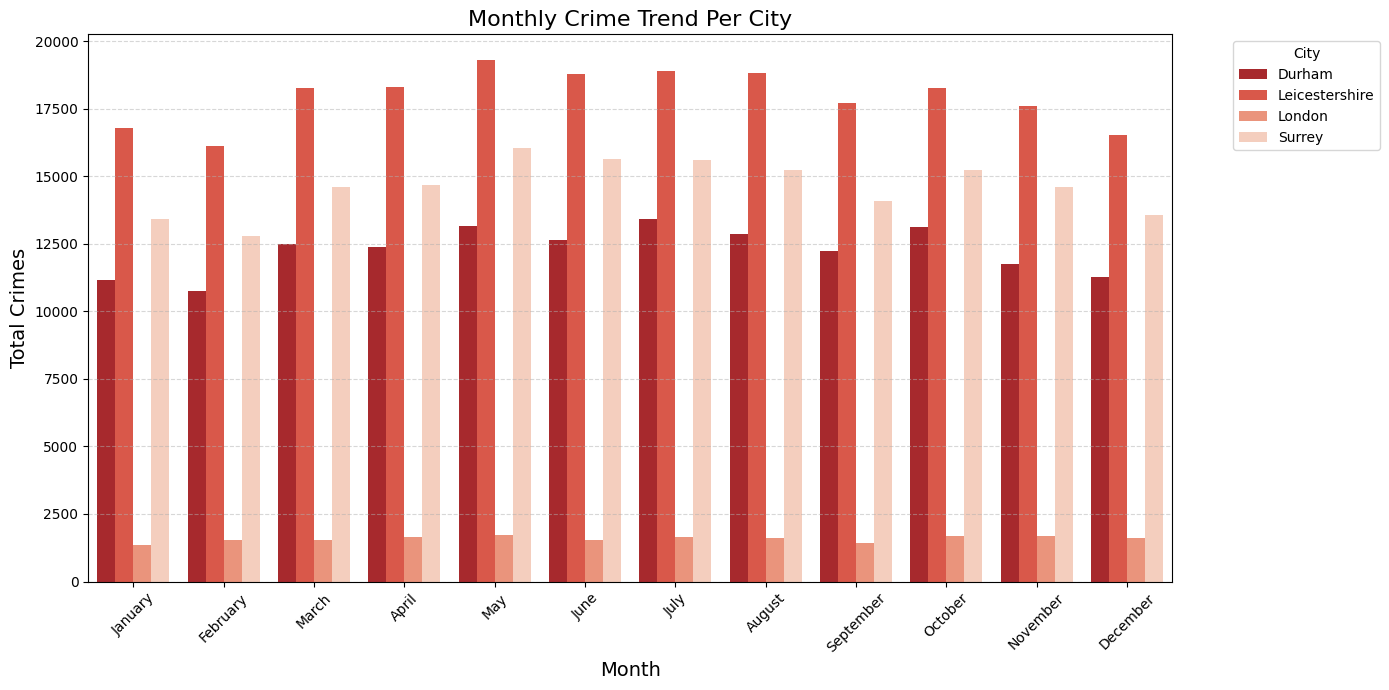

In [50]:
plt.figure(figsize=(14, 7))

sns.barplot(
    data=Monthly_Crime_ByCity_pd,
    x="Month_Name",
    y="Total_Crimes",
    hue="City",        # separate bars per city
    palette="Reds_r")

plt.title("Monthly Crime Trend Per City", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Crimes", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# **ACTIVITY-2**

## Step-1: Import Libraries and Start a Spark Session

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Step-2: Loading Dataset

In [135]:
df = pd.read_csv('/content/TitanicData.csv')

# Step-3: Data Preprocessing

In [137]:
# Rename a single column
df = df.rename(columns={"Sex": "Gender"})

In [138]:
# Checking for Missing data and displaying data types of each column
print("Dtypes:")
print(df.dtypes)

Dtypes:
PassengerId      int64
Pclass           int64
Name            object
Gender          object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Survived         int64
dtype: object


In [98]:
# Checking for duplicate rows
print(f"Number of duplicate rows in the dataset: {df.duplicated().sum()}")

Number of duplicate rows in the dataset: 0


In [139]:
print("Missing values per column:")
display(df.isna().sum())

Missing values per column:


,0
PassengerId,0
Pclass,0
Name,0
Gender,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687


In [93]:
#Removing cabin column due to higher missing values
df = df.drop(columns=['Cabin'])

In [94]:
# Remove rows where 'Embarked' is null
df = df.dropna(subset=['Embarked'])

#After filling values check for null values
print(f"Number of null values: {df['Embarked'].isna().sum()}")

Number of null values: 0


In [97]:
#Fill missing Age values with the mean
age_mean = df['Age'].mean()

df['Age'] = df['Age'].fillna(age_mean)

# Convert Age column to integer
df['Age'] = df['Age'].astype(int)

df['Age'].info()
df.head()

<class 'pandas.core.series.Series'>
Index: 889 entries, 0 to 890
Series name: Age
Non-Null Count  Dtype
--------------  -----
889 non-null    int64
dtypes: int64(1)
memory usage: 13.9 KB


,PassengerId,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,1
4,5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,0


In [140]:
# Converting categorical data into numeric data for sex column
df['Gender'] = df['Gender'].str.strip().str.lower().map({'male': 0, 'female': 1})
df['Gender'].head()

,Gender
0,0
1,1
2,1
3,1
4,0


## Step-5: EDA Analysis

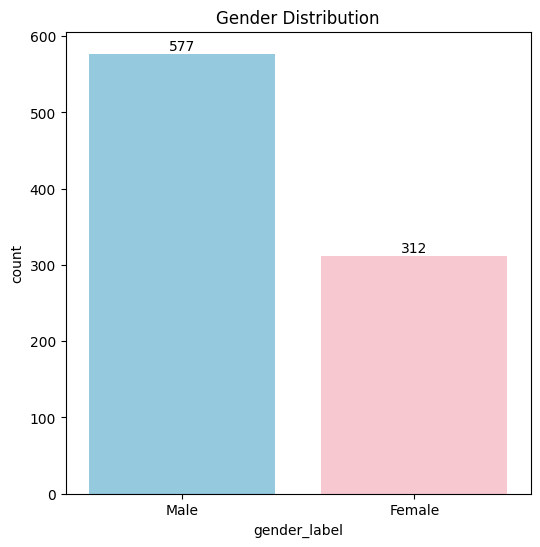

In [100]:
# Exploring the Gender distribution
from sklearn.preprocessing import LabelEncoder
df_model = df.copy()
label_encoder = LabelEncoder()
df_model['Gender_Label'] = label_encoder.fit_transform(df_model['Gender'])
df_model['gender_label'] = df['Gender'].map({0: 'Male', 1: 'Female'})

# Plot
plt.figure(figsize=(6,6))
ax = sns.countplot(x='gender_label', data=df_model, hue='gender_label', palette=['skyblue', 'pink'], dodge=False, legend=False)
plt.title('Gender Distribution')

# Add counts on top of each bar
for container in ax.containers:
    ax.bar_label(container)

plt.show()

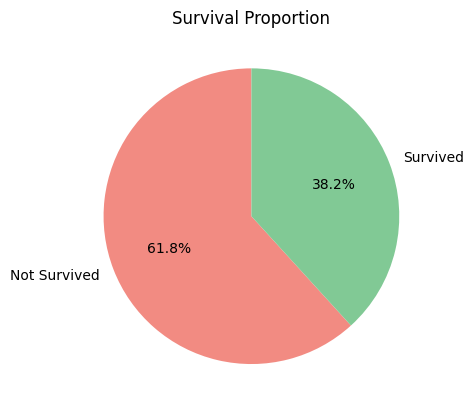

In [101]:
# Exploring the Survived distribution
df_plot = df.copy()
colors = ['#F28B82', '#81C995'] #Here I have used soft colours since generic red and green were aggresively bright

# Plot with proper labels
df['Survived'].value_counts().sort_index().rename(
    index={0: 'Not Survived', 1: 'Survived'}
).plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

plt.ylabel('')
plt.title('Survival Proportion')
plt.show()

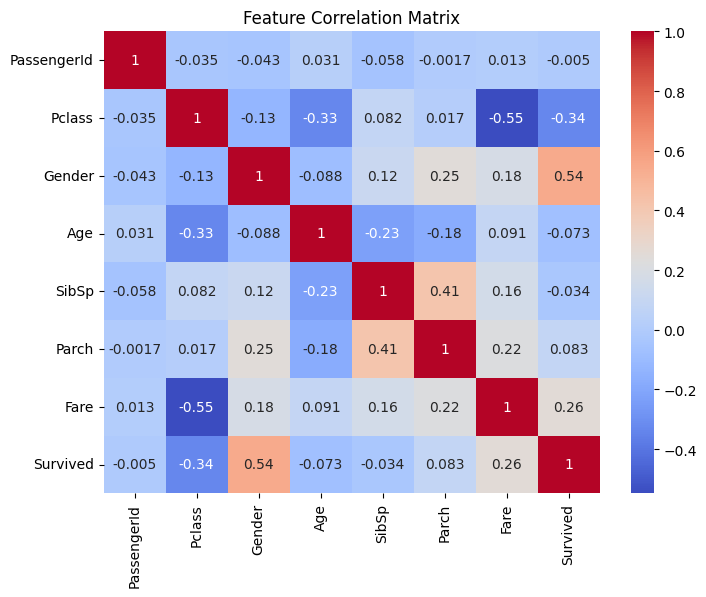

In [102]:
# Correlation between columns
numeric_df = df.select_dtypes(include='number')
corr = numeric_df.corr()

#plot
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [103]:
# Checking direct correlation with target value Survived
corr['Survived'].sort_values(ascending=False)

,Survived
Survived,1.000000
Gender,0.541585
Fare,0.255290
Parch,0.083151
PassengerId,-0.005028
SibSp,-0.034040
Age,-0.072695
Pclass,-0.335549


### 1) Since both Pclass and Fare are negatively correlated with each other, and Pclass shows a stronger correlation with the target variable Survived, I would prefer to retain Pclass over the Fare feature.
### 2) I plan to combine Parch and SibSp into a single feature, as their individual correlations with the target are weak, but together they may provide stronger predictive value.
### 3) I will drop PassengerId, Name, Ticket from the dataset, as they are unique identifiers that do not carry predictive information for the target variable and are unlikely to contribute to the model’s performance.

# Step-6: Feature Extraction

In [104]:
# Feature extraction
# Drop columns PassengerId, Name, Fare and Ticket
df = df.drop(columns=['PassengerId', 'Name', 'Fare', 'Ticket'], errors='ignore')
df.head()

,Pclass,Gender,Age,SibSp,Parch,Embarked,Survived
0,3,0,22,1,0,S,0
1,1,1,38,1,0,C,1
2,3,1,26,0,0,S,1
3,1,1,35,1,0,S,1
4,3,0,35,0,0,S,0


In [105]:
#Combining the Parch and Sibsp columns into one column and then dropping the columns
df['FamilyMembers'] = df['SibSp'] + df['Parch'] + 1
df.drop(columns=['SibSp', 'Parch'], inplace=True)
df

,Pclass,Gender,Age,Embarked,Survived,FamilyMembers
0,3,0,22,S,0,2
1,1,1,38,C,1,2
2,3,1,26,S,1,1
3,1,1,35,S,1,2
4,3,0,35,S,0,1
...,...,...,...,...,...,...
886,2,0,27,S,0,1
887,1,1,19,S,1,1
888,3,1,29,S,0,4
889,1,0,26,C,1,1


In [106]:
#Converting Dataframe df to pyspark
df = spark.createDataFrame(df)

In [107]:
from pyspark.sql.functions import col, when

df = df.withColumn(
    "Embarked",
    when(col("Embarked") == "Q", 2)
    .when(col("Embarked") == "S", 1)
    .when(col("Embarked") == "C", 0)
)

In [108]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer
from pyspark.ml import Pipeline

# Impute missing values
age_imputer = Imputer(inputCols=["Age"], outputCols=["Age"])

# Encode categorical variables
gender_indexer = StringIndexer(inputCol="Gender", outputCol="Gender_Label")
embarked_indexer = StringIndexer(inputCol="Embarked", outputCol="Embarked_Label")

# Assemble features into a vector
assembler = VectorAssembler(
    inputCols=["Pclass", "Age", "Gender_Label", "Embarked_Label", "FamilyMembers"],
    outputCol="features"
)

# Convert target to numeric label
survived_indexer = StringIndexer(inputCol="Survived", outputCol="label")

In [109]:
# Build the pipeline
pipeline = Pipeline(stages=[age_imputer, gender_indexer, embarked_indexer, survived_indexer, assembler])

# Fit and transform the pipeline
cleaner = pipeline.fit(df)
clean_data = cleaner.transform(df)

# Keep only label and features
clean_data = clean_data.select(["label", "features"])
clean_data.show(10, truncate=False)

+-----+----------------------+
|label|features              |
+-----+----------------------+
|0.0  |[3.0,22.0,0.0,0.0,2.0]|
|1.0  |[1.0,38.0,1.0,1.0,2.0]|
|1.0  |[3.0,26.0,1.0,0.0,1.0]|
|1.0  |[1.0,35.0,1.0,0.0,2.0]|
|0.0  |[3.0,35.0,0.0,0.0,1.0]|
|0.0  |[3.0,29.0,0.0,2.0,1.0]|
|0.0  |[1.0,54.0,0.0,0.0,1.0]|
|0.0  |[3.0,2.0,0.0,0.0,5.0] |
|1.0  |[3.0,27.0,1.0,0.0,3.0]|
|1.0  |[2.0,14.0,1.0,1.0,2.0]|
+-----+----------------------+
only showing top 10 rows


In [111]:
# Train/test split (70/30)
(training, testing) = clean_data.randomSplit([0.7, 0.3])

print(f"Training set count: {training.count()}")
print(f"Testing set count: {testing.count()}")

Training set count: 614
Testing set count: 275


# Step-8: Model Training and Performance Evaluation

## Naive Bayes

In [112]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize model
nb = NaiveBayes(
    featuresCol="features",
    labelCol="label"
)

# Train model
nb_model = nb.fit(training)

# Predict on test data
nb_test_results = nb_model.transform(testing)

In [129]:
# Prepare prediction–label pairs for model evaluation
evaluator = nb_test_results.select("prediction", "label")
evaluator.show(5)

from pyspark.mllib.evaluation import MulticlassMetrics

# Convert to RDD of (prediction, label)
prediction_and_labels = evaluator.rdd.map(lambda row: (row.prediction, row.label))

# Initialize MulticlassMetrics
nb_multiclass_metrics = MulticlassMetrics(prediction_and_labels)

# Metrics
nb_accuracy = nb_multiclass_metrics.accuracy
nb_precision = nb_multiclass_metrics.weightedPrecision
nb_recall = nb_multiclass_metrics.weightedRecall
nb_f1 = nb_multiclass_metrics.weightedFMeasure()


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows


In [114]:
print(f"Naive Bayes Accuracy: {nb_accuracy}")
print(f"Naive Bayes Precision Score: {nb_precision}")
print(f"Naive Bayes Recall Score: {nb_recall}")
print(f"Naive Bayes F1 Score: {nb_f1}")

Naive Bayes Accuracy: 0.7963636363636364
Naive Bayes Precision Score: 0.7962978956527342
Naive Bayes Recall Score: 0.7963636363636364
Naive Bayes F1 Score: 0.7926765787765447


## Decision Tree

In [115]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize model
dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="label"
)

# Train model
dt_model = dt.fit(training)

# Predict on test data
dt_test_results = dt_model.transform(testing)

In [123]:
# Prepare prediction–label pairs for model evaluation
evaluator = dt_test_results.select("prediction", "label")
evaluator.show(5)

from pyspark.mllib.evaluation import MulticlassMetrics

# Convert to RDD of (prediction, label)
prediction_and_labels = evaluator.rdd.map(lambda row: (row.prediction, row.label))

# Initialize MulticlassMetrics
dt_multiclass_metrics = MulticlassMetrics(prediction_and_labels)

# Metrics
dt_accuracy = dt_multiclass_metrics.accuracy
dt_precision = dt_multiclass_metrics.weightedPrecision
dt_recall = dt_multiclass_metrics.weightedRecall
dt_f1 = dt_multiclass_metrics.weightedFMeasure()

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows


In [117]:
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Decision Tree  Precision Score: {dt_precision}")
print(f"Decision Tree  Recall Score: {dt_recall}")
print(f"Decision Tree  F1 Score: {dt_f1}")

Decision Tree Accuracy: 0.8254545454545454
Decision Tree  Precision Score: 0.8277044694435998
Decision Tree  Recall Score: 0.8254545454545454
Decision Tree  F1 Score: 0.8218293553493281


# Logistic Regression

In [118]:
from pyspark.ml.classification import LogisticRegression

# Initialize model
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100
)

# Train model
lr_model = lr.fit(training)

# Predict on test data
lr_test_results = lr_model.transform(testing)

In [122]:
# Prepare prediction–label pairs for model evaluation
evaluator = lr_test_results.select("prediction", "label")
evaluator.show(5)

from pyspark.mllib.evaluation import MulticlassMetrics

# Convert to RDD of (prediction, label)
prediction_and_labels = evaluator.rdd.map(lambda row: (row.prediction, row.label))

# Initialize MulticlassMetrics
lr_multiclass_metrics = MulticlassMetrics(prediction_and_labels)

# Metrics
lr_accuracy = lr_multiclass_metrics.accuracy
lr_precision = lr_multiclass_metrics.weightedPrecision
lr_recall = lr_multiclass_metrics.weightedRecall
lr_f1 = lr_multiclass_metrics.weightedFMeasure()

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  0.0|
|       1.0|  0.0|
|       1.0|  0.0|
|       1.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows


In [124]:
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Logistic Regression Precision Score: {lr_precision}")
print(f"Logistic Regression Recall Score: {lr_recall}")
print(f"Logistic Regression F1 Score: {lr_f1}")

Logistic Regression Accuracy: 0.8
Logistic Regression Precision Score: 0.7989393770235571
Logistic Regression Recall Score: 0.8
Logistic Regression F1 Score: 0.7991973540360637


# Random Forest

In [125]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize model
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=100
)

# Train model
rf_model = rf.fit(training)

# Predict on test data
rf_test_results = rf_model.transform(testing)

In [126]:
# Prepare prediction–label pairs for model evaluation
evaluator = rf_test_results.select("prediction", "label")
evaluator.show(5)

from pyspark.mllib.evaluation import MulticlassMetrics

# Convert to RDD of (prediction, label)
prediction_and_labels = evaluator.rdd.map(lambda row: (row.prediction, row.label))

# Initialize MulticlassMetrics
rf_multiclass_metrics = MulticlassMetrics(prediction_and_labels)

# Metrics
rf_accuracy = rf_multiclass_metrics.accuracy
rf_precision = rf_multiclass_metrics.weightedPrecision
rf_recall = rf_multiclass_metrics.weightedRecall
rf_f1 = rf_multiclass_metrics.weightedFMeasure()

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  0.0|
|       1.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows


In [127]:
print(f"Logistic Regression Accuracy: {rf_accuracy}")
print(f"Logistic Regression Precision Score: {rf_precision}")
print(f"Logistic Regression Recall Score: {rf_recall}")
print(f"Logistic Regression F1 Score: {rf_f1}")

Logistic Regression Accuracy: 0.8181818181818182
Logistic Regression Precision Score: 0.8184370015948963
Logistic Regression Recall Score: 0.8181818181818181
Logistic Regression F1 Score: 0.8153492477267597


# Comparing the Models based on their Accuracy

In [128]:
# Since accuracy is a PySpark Column, convert it to float
nb_accuracy = float(nb_accuracy)
dt_accuracy = float(dt_accuracy)
lr_accuracy = float(lr_accuracy)
rf_accuracy = float(rf_accuracy)

# Now store in dictionary
model_accuracies = {
    "Naive Bayes": nb_accuracy,
    "Decision Tree": dt_accuracy,
    "Logistic Regression": lr_accuracy,
    "Random Forest": rf_accuracy
}

# Sort models by accuracy
sorted_models = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)

# Print results neatly
print("Model Performance Summary")
print("-----------------------------------------------")
for model, acc in sorted_models:
    print(f"{model:<20}: {acc:.4f}")


Model Performance Summary
-----------------------------------------------
Decision Tree       : 0.8255
Random Forest       : 0.8182
Logistic Regression : 0.8000
Naive Bayes         : 0.7964
